<a href="https://colab.research.google.com/github/emmanuelmadoery/MMM-bayesiano/blob/main/Maketing_Mix_Modeling_bayesiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalación del paquete Meridian desde PyPI:
# Se especifica `google-meridian` con extras opcionales:
# - `colab`: configura dependencias útiles para ejecutar en Google Colab.
# - `and-cuda`: instala soporte para aceleración por GPU con CUDA (útil para MCMC más rápido).
# Se usa `--upgrade` para asegurar que se instale la última versión disponible.

!pip install --upgrade google-meridian[colab,and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.6/229.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.0/886.0 kB 57.2 MB/s eta 0:00:00
  Attempting uninstall: natsort
    Found existing installation: natsort 8.4.0
    Uninstalling natsort-8.4.0:
      Successfully uninstalled natsort-8.4.0


In [ ]:
# ========================
# IMPORTACIÓN DE PAQUETES
# ========================

# Numpy y Pandas: manipulación de datos numéricos y estructuras tabulares.
import numpy as np
import pandas as pd

# TensorFlow y TensorFlow Probability: base del modelo bayesiano en Meridian.
import tensorflow as tf
import tensorflow_probability as tfp

# ArviZ: análisis bayesiano y visualización de distribuciones a posteriori.
import arviz as az

# xarray: estructuras tipo Dataset multidimensional (usado en resultados de inferencia).
import xarray as xr

# IPython: utilidades para entorno interactivo (no se usa aún, pero útil para display).
import IPython

# ===============================
# MÓDULOS DE MERIDIAN (OFICIALES)
# ===============================

# Constantes internas de Meridian.
from meridian import constants

# Módulos de carga y preparación de datos.
from meridian.data import load
from meridian.data import test_utils
from meridian.data.input_data import InputData
from meridian.data import input_data  # útil para funciones auxiliares

# Módulos de modelado y especificación del modelo.
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.model.model import Meridian  # clase principal del modelo

# Módulos de análisis del modelo entrenado.
from meridian.analysis import optimizer     # optimización de presupuesto
from meridian.analysis import analyzer      # cálculo de métricas y efectos
from meridian.analysis import visualizer    # gráficos y visualizaciones
from meridian.analysis import summarizer    # resumen HTML del modelo
from meridian.analysis import formatter     # formato de métricas para reporting

# =============================
# UTILIDADES ADICIONALES
# =============================

# tqdm: barra de progreso útil en loops largos o procesos MCMC.
from tqdm import tqdm
import time

# matplotlib: visualización básica de datos.
import matplotlib.pyplot as plt

# =============================
# OCULTAR WARNINGS
# =============================

import warnings

# 🚫 Ignorar todos los warnings (general)
warnings.filterwarnings('ignore')


# ============================
# VERIFICACIÓN DEL ENTORNO
# ============================

# Verificar si hay GPU disponible y cuánta RAM tiene el entorno.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9

print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 54.8 gigabytes of available RAM

Num GPUs Available:  1
Num CPUs Available:  1


In [ ]:
# =====================================
# CARGAR Y FORMATEAR LOS DATOS ORIGINALES
# =====================================

# Ruta al archivo CSV con todos los datos consolidados.
file_path = 'Dataset_Consolidado_con_Ingresos_Totales_Ajustados.csv'

# Cargar los datos en un DataFrame.
df = pd.read_csv(file_path)


# =====================================
# CONVERSIÓN DE LA COLUMNA DE FECHA
# =====================================

# Convertir la columna 'fecha' al tipo datetime de Pandas.
# Esto es necesario porque Meridian requiere que la dimensión temporal esté en formato datetime.
df['fecha'] = pd.to_datetime(df['fecha'])

# Mostrar el dataframe
df.head()

fecha   inv_google     inv_meta  inv_tiktok  inv_tv  inv_programmatic  \
0 2022-01-01  5932.887256  3785.856893         0.0     0.0       7079.573136   
1 2022-01-08  5256.916460  4022.403715         0.0     0.0       7338.789999   
2 2022-01-15  4444.348251  2255.554310         0.0     0.0       7100.295836   
3 2022-01-22  5388.276804  4270.892664         0.0     0.0       7362.632928   
4 2022-01-29  4592.659165  3046.633637         0.0     0.0       7475.364362   

         emails  lluvia  busquedas_google  adstock_investment_google  ...  \
0  45087.563032     0.0       5676.250242                5932.887256  ...   
1  49376.834250     0.0       5591.495567                7036.782637  ...   
2  53750.260495     1.0       5000.000000                6614.711915  ...   
3  46658.277726     1.0       5682.560014                7247.272926  ...   
4  52526.877531     0.0       5000.000000                6653.577031  ...   

     ing_totales  ing_totales_lluvia       ing_base  ing_publicidad  \
0  152362.799082       152362.799082  143667.311370   141010.298599   
1  173335.983100       173335.983100  143799.990634   162152.991965   
2  176609.955798       194270.951378  144281.648846   166609.955798   
3  170450.875780       187495.963358  145343.216560   159085.755753   
4  176494.532221       176494.532221  146502.191881   166494.532221   

   ing_publicidad_lluvia  ing_base_mas_totales_lluvia  ingresos_canales  \
0          141010.298599                296030.110452     152362.799082   
1          162152.991965                317135.973733     173335.983100   
2          183270.951378                338552.600223     176609.955798   
3          174994.331328                332839.179918     170450.875780   
4          166494.532221                322996.724103     176494.532221   

   ingresos_canales_lluvia  ingresos_base  ingresos_totales_ajustados  
0            152362.799082  143667.311370               296030.110452  
1            173335.983100  143799.990634               317135.973733  
2            194270.951378  144281.648846               338552.600223  
3            187495.963358  145343.216560               332839.179918  
4            176494.532221  146502.191881               322996.724103  

[5 rows x 46 columns]

In [ ]:
# =======================================
# DEFINIR LAS COLUMNAS CLAVE DEL MODELO
# =======================================

# Lista de columnas del DataFrame que contienen el gasto por canal de medios pagados.
media_spend = ['inv_google', 'inv_meta', 'inv_tiktok', 'inv_tv', 'inv_programmatic']

# En este ejemplo, usamos directamente las columnas de inversión como proxy de exposición (sin datos de alcance).
# Esto es válido según la documentación si no se cuenta con datos de reach/frequency.
media = media_spend

# Crear un diccionario que mapea cada columna de inversión al nombre del canal sin el prefijo "inv_".
# Este diccionario se usa para estandarizar nombres internos en Meridian.
media_spend_to_channel = {col: col.replace("inv_", "") for col in media_spend}
media_to_channel = media_spend_to_channel.copy()  # En este caso, coinciden porque usamos inversión como exposición.


# ======================================
# MAPEO DE COLUMNAS PARA EL LOADER
# ======================================

# Crear un objeto `CoordToColumns` que indica qué columnas del DataFrame corresponden a:
# - La dimensión temporal.
# - La dimensión geográfica.
# - El KPI objetivo (en este caso: ingresos ajustados).
# - Variables de control (factores externos que influyen en el KPI pero no son marketing).
# - Medios pagados (en este caso, usando inversión como exposición).
# - Medios orgánicos (ej: envíos de emails, tráfico directo, etc.).
coord_to_columns = load.CoordToColumns(
    time='fecha',                                  # (str) Columna temporal.
    geo='geo',                                     # (str) Columna geográfica.
    kpi='ingresos_totales_ajustados',              # (str) KPI a modelar.
    controls=['lluvia', 'busquedas_google'],       # (list[str]) Variables de control opcionales.
    media=media,                                   # (list[str]) Columnas de exposición de medios.
    media_spend=media_spend,                       # (list[str]) Columnas de gasto de medios.
    organic_media=['emails'],                      # (list[str]) Medios orgánicos, si existen.
    reach=None,                                    # (list[str]) Columnas de alcance (opcional, no usado aquí).
    frequency=None,                                # (list[str]) Columnas de frecuencia (opcional).
    rf_spend=None,                                 # (list[str]) Gasto asociado a reach/frequency (opcional).
    non_media_treatments=None,                     # (list[str]) Intervenciones no mediáticas (opcional).
    revenue_per_kpi=None                           # (str) Valor monetario por conversión (opcional, si kpi no es revenue directo).
)


# ===========================================
# CARGA DE DATOS CON DataFrameDataLoader
# ===========================================

# Crear el loader que toma un DataFrame en formato ancho (wide) y lo transforma a los tensores que espera Meridian.
loader = load.DataFrameDataLoader(
    df=df,                                         # (pandas.DataFrame) Tu dataset.
    kpi_type='revenue',                            # (str) 'revenue' o 'conversion'.
    coord_to_columns=coord_to_columns,             # (CoordToColumns) El mapeo creado arriba.
    media_to_channel=media_to_channel,             # (dict) Mapeo de medios pagados.
    media_spend_to_channel=media_spend_to_channel, # (dict) Mapeo de gasto en medios pagados.
)

# Cargar los datos procesados. Esto generará las estructuras internas necesarias para el modelo.
loaded_data = loader.load()
loaded_data.as_dataset()

<xarray.Dataset> Size: 54kB
Dimensions:                (time: 156, geo: 1, control_variable: 2,
                            media_channel: 5, media_time: 156,
                            organic_media_channel: 1)
Coordinates:
  * time                   (time) <U28 17kB '2022-01-01' ... '2024-12-21'
  * geo                    (geo) <U12 48B 'national_geo'
  * control_variable       (control_variable) object 16B 'lluvia' 'busquedas_...
  * media_channel          (media_channel) object 40B 'google' ... 'programma...
  * media_time             (media_time) <U28 17kB '2022-01-01' ... '2024-12-21'
  * organic_media_channel  (organic_media_channel) object 8B 'emails'
Data variables:
    kpi                    (geo, time) float64 1kB 2.96e+05 ... 6.456e+05
    population             (geo) float64 8B 1.0
    controls               (geo, time, control_variable) float64 2kB 0.0 ... ...
    revenue_per_kpi        (geo, time) float64 1kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    media                  (geo, media_time, media_channel) float64 6kB 5.933...
    media_spend            (geo, time, media_channel) float64 6kB 5.933e+03 ....
    organic_media          (geo, media_time, organic_media_channel) float64 1kB ...

In [ ]:
# =======================================
# DEFINIR LA DISTRIBUCIÓN A PRIORI DEL ROI
# =======================================

# Se define una distribución Log-Normal como distribución a priori para el ROI (Retorno de Inversión)
# Esta elección es compatible con la reparametrización de Meridian basada en ROI.
# LogNormal asegura que el ROI sea siempre positivo.

# Crear una única distribución LogNormal vectorizada para todos los canales
roi_m_prior = tfp.distributions.LogNormal(
    loc=[1.2, 1.2, 0.6, 0.6, 0.6],    # loc individual para cada canal (mu)
    scale=[0.2, 0.3, 0.4, 0.4, 0.4],  # scale individual para cada canal (sigma)
    name="roi_m"
)

# Definir el prior completo con TODOS los parámetros personalizables
prior = prior_distribution.PriorDistribution(
    roi_m=roi_m_prior,  # ROI para medios pagados (vectorizado)
    roi_rf=tfp.distributions.LogNormal(loc=1.6, scale=0.4, name=constants.ROI_RF),  # ROI para medios con Reach/Frequency
    mroi_m=tfp.distributions.LogNormal(loc=1.6, scale=0.4, name=constants.MROI_M),  # ROI marginal para medios pagados
    mroi_rf=tfp.distributions.LogNormal(loc=1.6, scale=0.4, name=constants.MROI_RF),  # ROI marginal para medios con Reach/Frequency

    eta_m=tfp.distributions.HalfNormal(5.0),    # Regularización entre geos para medios pagados
    eta_rf=tfp.distributions.HalfNormal(5.0),   # Regularización entre geos para medios con Reach/Frequency
    eta_om=tfp.distributions.HalfNormal(5.0),   # Regularización entre geos para medios orgánicos
    eta_orf=tfp.distributions.HalfNormal(5.0),  # Regularización entre geos para medios orgánicos con Reach/Frequency

    xi_c=tfp.distributions.HalfNormal(5.0),     # Regularización entre geos para controles (lluvia)
    xi_n=tfp.distributions.HalfNormal(5.0),     # Regularización entre geos para tratamientos no mediáticos (descuentos)

    beta_m=tfp.distributions.HalfNormal(5.0),   # Prior para betas de medios pagados (no se usa en este ejemplo porque tenemos paid_media_prior_type='roi' en el model_spec)
    beta_rf=tfp.distributions.HalfNormal(5.0),  # Prior para betas de medios con Reach/Frequency (no se usa en este ejemplo porque tenemos paid_media_prior_type='roi' en el model_spec)
    beta_om=tfp.distributions.HalfNormal(0.3),  # Prior para betas de medios orgánicos
    beta_orf=tfp.distributions.HalfNormal(5.0), # Prior para betas de medios orgánicos con Reach/Frequency

    gamma_c=tfp.distributions.Normal(0.0, 5.0),  # Prior para controles (lluvia)
    gamma_n=tfp.distributions.Normal(0.0, 5.0),  # Prior para tratamientos no mediáticos (descuentos)

    sigma=tfp.distributions.HalfNormal(5.0),     # Prior para el ruido residual (error)

    # Priors para el efecto de Adstock (permite ajustar la tasa de decaimiento)
    alpha_m=tfp.distributions.Uniform(0.0, 1.0),     # Medios pagados
    alpha_om=tfp.distributions.Uniform(0.0, 1.0),    # Medios orgánicos
    alpha_rf=tfp.distributions.Uniform(0.0, 1.0),    # Medios pagados con datos de alcance y frecuencia
    alpha_orf=tfp.distributions.Uniform(0.0, 1.0)    # Medios orgánicos con datos de alcance y frecuencia
)

# ============================================
# CONFIGURACIÓN DE LA ESPECIFICACIÓN DEL MODELO
# ============================================

# Se define un objeto ModelSpec con los hiperparámetros y opciones de estructura.

model_spec = spec.ModelSpec(
    prior=prior,                                 # Prior definido arriba
    media_effects_dist='log_normal',             # 'log_normal' (default) o 'normal'
    hill_before_adstock=False,                   # Primero aplica adstock y luego Hill
    max_lag=8,                                   # Máximo lag (rezago) en semanas
    unique_sigma_for_each_geo=True,              # (solo para modelos geo-level). Error residual individual para cada geo o compartido (True/False)
    paid_media_prior_type='roi',                 # Reparametrización en función de ROI ('roi', 'mroi' o 'coefficient')
    roi_calibration_period=None,                 # Período para calibrar ROIs si se usa calibración. Para EXPERIMENTOS INCREMENTALES la pasamos la matriz roi_calibration_period
    rf_roi_calibration_period=None,              # Idem para Reach/Frequency
    knots=20,                                    # Número de nudos para baseline temporal (None usa default = 1 para modelos nacionales y 'n_times' para modelos geo). Ej: [1, 13, 26, 39, 52] uno en cada trimestre
    baseline_geo=None,                           # Geo de referencia para baseline en modelos geográficos ('España')
    holdout_id=None,                             # Holdout ID si se usa validación fuera de muestra. Un array booleano holdout_id con valores [true, false]
    control_population_scaling_id=None           # Scaling ID para población de control. controls=['impresiones_competencia', 'lluvia']. control_population_scaling_id = [True, False]
)


# ============================
# CREAR Y ENTRENAR EL MODELO
# ============================

# Crear una instancia del modelo con los datos cargados y la configuración definida.
mmm = Meridian(
    input_data=loaded_data,
    model_spec=model_spec
)


# ======================================
# MUESTREO DESDE LA DISTRIBUCIÓN A PRIORI
# ======================================

# Genera 500 muestras de los parámetros del modelo usando solo las distribuciones a priori (sin usar los datos aún).
# Sirve para visualizar el conocimiento previo sobre los parámetros.
mmm.sample_prior(n_draws=500)


# =========================================
# ENTRENAMIENTO DEL MODELO CON MCMC POSTERIOR
# =========================================

# Inicia el muestreo MCMC usando el algoritmo NUTS (No-U-Turn Sampler).
# Esto estima la distribución a posteriori de todos los parámetros, dado los datos observados.

with tqdm(total=5 * 1000, desc="Progreso del entrenamiento") as pbar:
    mmm.sample_posterior(
        n_chains=5,      # Número de cadenas paralelas (ayuda a verificar convergencia).
        n_adapt=500,     # Número de pasos de calentamiento por cadena (subir a 1000 o 2000 si los R-hat son altos o no hay convergencia)
        n_burnin=500,    # Iteraciones iniciales a descartar por cada cadena (puede estar entre 0 y 100 y solo subirlo si vemos en los gráficos trace plots que tarda en estabilizarse)
        n_keep=1000,     # Iteraciones por cadena que se conservarán para inferencia. Subir a 2000 si los intervalos de credibilidad son muy anchos o los gráficos de densidad "ruidosos"
    )
    pbar.update(5 * 1000)  # Actualiza barra de progreso (visual).

Progreso del entrenamiento: 100%|██████████| 5000/5000 [07:52<00:00, 10.58it/s]


📊 Métricas de Precisión del Modelo (R², MAPE, WMAPE):


metric geo_granularity     value
0  R_Squared        national  0.995546
1       MAPE        national  0.007911
2      wMAPE        national  0.007788

alt.LayerChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

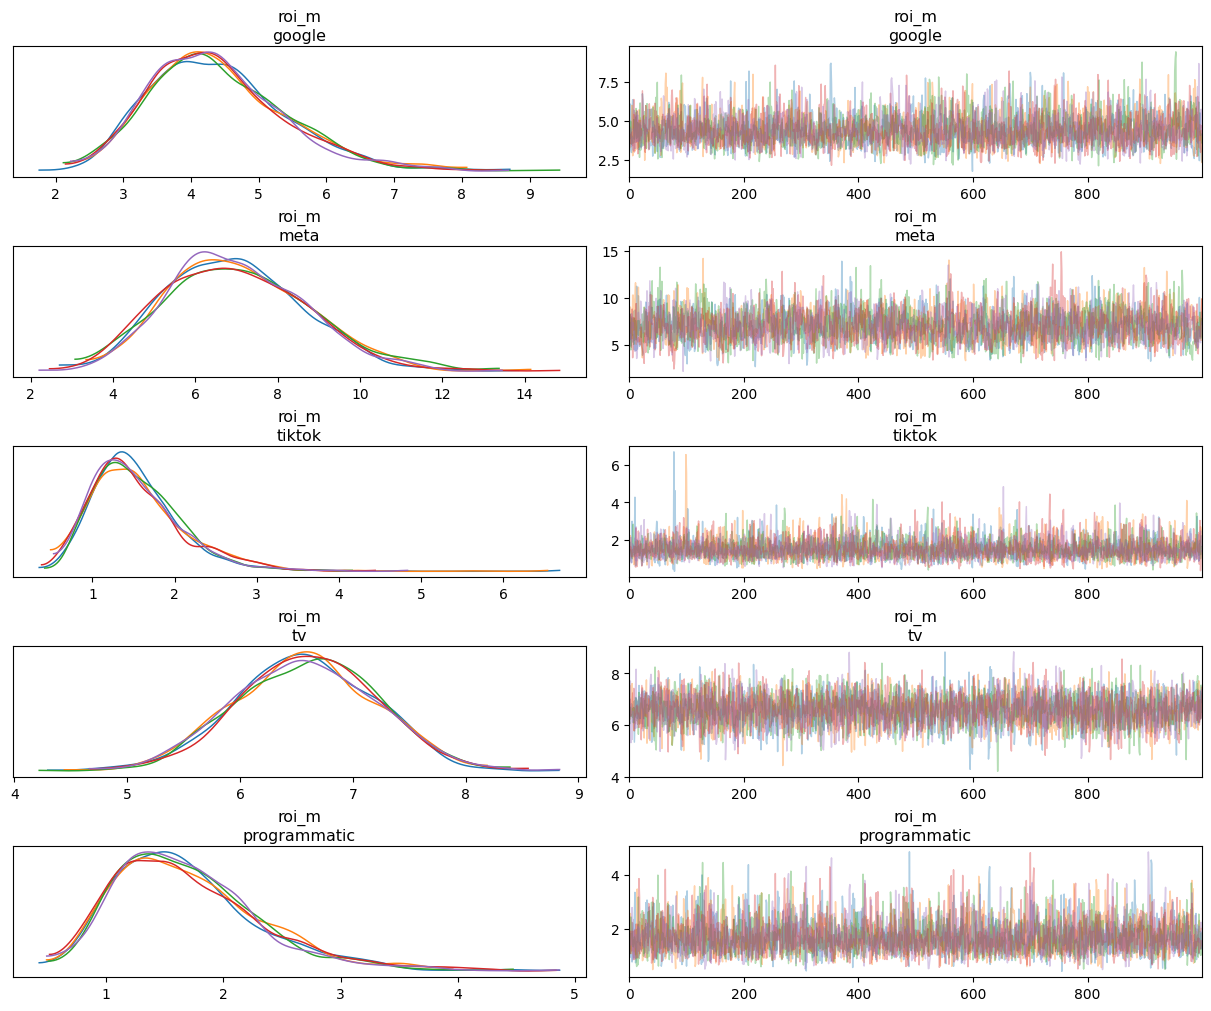

In [ ]:
# ===================================
# MÉTRICAS DE PRECISIÓN DEL MODELO
# ===================================

# Crear un objeto de diagnóstico
model_diagnostics = visualizer.ModelDiagnostics(mmm)

# 📋 Tabla de precisión predictiva (R², MAPE, WMAPE)
predictive_accuracy = model_diagnostics.predictive_accuracy_table()

print("📊 Métricas de Precisión del Modelo (R², MAPE, WMAPE):")
display(predictive_accuracy)

# ==================================================
# DIAGNÓSTICOS DE CONVERGENCIA Y DISTRIBUCIÓN POSTERIOR
# ==================================================

# Crear un objeto de diagnóstico para evaluar la calidad del muestreo MCMC.
model_diagnostics = visualizer.ModelDiagnostics(mmm)

# R-hat: métrica de convergencia del MCMC (debe ser < 1.1 para indicar convergencia adecuada).
# Visualiza un boxplot con los valores de R-hat para todos los parámetros.
fig = model_diagnostics.plot_rhat_boxplot()
fig.show()

# 🔍 Comparación visual entre la distribución a priori y a posteriori de los parámetros del modelo.
# Permite ver cómo los datos actualizaron nuestras creencias iniciales.
fig = model_diagnostics.plot_prior_and_posterior_distribution()
fig.show()

# =======================================
# CURVAS DE RESPUESTA Y DECAY DE ADSTOCK
# =======================================

# Crear análisis de efectos dinámicos
media_effects = visualizer.MediaEffects(mmm)

# 📉 Curvas de respuesta (saturación - función Hill)
fig_response_curves = media_effects.plot_response_curves()
fig_response_curves.show()

# ⏳ Curvas de adstock (decaimiento en el tiempo)
fig_adstock_decay = media_effects.plot_adstock_decay()
fig_adstock_decay.show()

# ==============================================
# VISUALIZACIÓN DE LA TRAZA Y POSTERIOR DE ROI
# ==============================================

# Lista de parámetros que quieres visualizar (puedes especificar uno o todos los canales)
parameters_to_plot = ["roi_m"]  # Esto grafica todos los canales si roi_m es vectorial

for param in parameters_to_plot:
    az.plot_trace(
        mmm.inference_data,           # Datos inferidos del modelo Meridian
        var_names=param,              # Nombre del parámetro a visualizar
        compact=False,                # Muestra una fila por parámetro (más claro)
        backend_kwargs={
            "constrained_layout": True  # Optimiza el layout de la figura
        }
    )

In [ ]:
# =========================================
# REPORTE DEL MODELO
# =========================================

# Crear el objeto summarizer a partir del modelo entrenado
mmm_summarizer = summarizer.Summarizer(mmm)

# Definir ruta donde guardar el archivo
output_dir = "/content"  # o tu carpeta de Drive
output_filename = "resumen_modelo_meridian.html"

# Definir fechas del período modelado (asegúrate de usar las reales)
start_date = "2022-01-01"   # cambia por la fecha real de inicio en tu data
end_date = "2024-12-21"     # cambia por la fecha real de fin

# Exportar el archivo HTML con el resumen
mmm_summarizer.output_model_results_summary(
    output_filename,
    output_dir,
    start_date,
    end_date
)

# Abrir en Colab
IPython.display.HTML(filename=f"{output_dir}/{output_filename}")

In [ ]:
# ========================================
# OPTIMIZACIÓN PRESUPUESTARIA
# ========================================

# Crear el optimizador desde el modelo entrenado
budget_optimizer = optimizer.BudgetOptimizer(mmm)

# Ejecutar la optimización con todos los parámetros configurables
optimization_results = budget_optimizer.optimize(
    use_posterior=True,              # Usar resultados posteriori (True) o solo prior (False)
    selected_times=None,             # Período a optimizar: ('2023-01-01', '2023-03-31') o None para todo
    fixed_budget=True,               # True = presupuesto fijo (se usa 'budget'), False = flexible (se usa ROI objetivo)
    budget=None,                     # Monto total si fixed_budget=True (None = usa gasto actual). Ej: 5000000
    pct_of_spend=None,               # Proporción deseada por canal (debe sumar 1.0). Ideal para ver resultados de estrategias concretas WhatIf. Ej: [0.2, 0.2, 0.2, 0.2, 0.2]
    spend_constraint_lower=None,     # Límite inferior por canal. El valor predeterminado es 0.3 para el presupuesto fijo y 1 para el presupuesto flexible. Ej: [0.5, 0.5, 0.3, 0.5, 0.4]
    spend_constraint_upper=None,     # Límite superior por canal. El valor predeterminado es 0.3 para el presupuesto fijo y 1 para el presupuesto flexible. Ej: [1.5, 1.5, 2.0, 1.3, 1.4]
    target_roi=None,                 # ROI objetivo (si fixed_budget=False). Ej: 3.0
    target_mroi=None,                # mROI objetivo (si fixed_budget=False). Ej: 2.5
    gtol=0.0001,                     # Tolerancia del gradiente (precisión de la optimización). Solo se aumenta si los cálculos son extremadamente lentos.
    use_optimal_frequency=True,      # Usar frecuencia óptima aprendida (True) o histórica (False)
    use_kpi=False,                   # Si KPI ≠ revenue, poner True. Si KPI = revenue, dejar False.
    confidence_level=0.9,            # Nivel de confianza para cálculos e intervalos.
    batch_size=1000                  # Tamaño del batch para evaluación (control de memoria). Bajarlo solo si hay errores de memoria.
)

# ================================
# Exportar y mostrar resultados
# ================================

filepath = '/content/drive/MyDrive'

# Guardar el resumen de optimización en HTML
optimization_results.output_optimization_summary(
    filename='optimization_output.html',
    filepath=filepath
)

# Mostrar dentro del notebook
IPython.display.HTML(filename=f'{filepath}/optimization_output.html')


In [ ]:
# ===========================
# AJUSTE DEL MODELO AL KPI
# ===========================

# Crear objeto para evaluar el ajuste del modelo en la muestra (in-sample).
model_fit = visualizer.ModelFit(mmm)

# 📈 Gráfico del KPI observado vs el KPI estimado por el modelo (por semana).
# Ideal para mostrar qué tan bien se ajusta el modelo a los datos reales.
fig = model_fit.plot_model_fit()
fig.show()

# ============================
# ANÁLISIS DE MEDIOS PAGADOS
# ============================

# Crear resumen de medios
media_summary = visualizer.MediaSummary(mmm)

# 💧 Waterfall chart: contribución de cada canal
fig_waterfall = media_summary.plot_contribution_waterfall_chart()
fig_waterfall.show()

# 🥧 Pie chart: proporción de contribución por canal
fig_pie = media_summary.plot_contribution_pie_chart()
fig_pie.show()

# 💸 Spend vs Contribución real
fig_spend_vs_contribution = media_summary.plot_spend_vs_contribution()
fig_spend_vs_contribution.show()

# 📊 ROI por canal
fig_roi_bar = media_summary.plot_roi_bar_chart()
fig_roi_bar.show()

# 🔁 ROI vs Efectividad
fig_roi_vs_effectiveness = media_summary.plot_roi_vs_effectiveness()
fig_roi_vs_effectiveness.show()

# 📈 ROI vs mROI
fig_roi_vs_mroi = media_summary.plot_roi_vs_mroi()
fig_roi_vs_mroi.show()

# =====================================================
# OPTIMIZACIÓN Y VISUALIZACIÓN DE PRESUPUESTO EN MERIDIAN
# =====================================================

# Crear objeto de optimización de presupuesto
budget_optimizer = optimizer.BudgetOptimizer(mmm)

# Ejecutar optimización de presupuesto
optimization_results = budget_optimizer.optimize(
    budget=None,                        # (float) Nuevo presupuesto total a optimizar. None = mantiene el actual.
    selected_times=None,                # (tuple(str, str)) Fechas de inicio y fin para optimizar. None = todo el período.
    spend_constraint_lower=None,        # (list[float] o float) Límite inferior de gasto por canal. None = sin límite explícito.
)

# ========================================
# VISUALIZACIÓN DE RESULTADOS DE OPTIMIZACIÓN
# ========================================

# 📊 Variación relativa en el gasto por canal (delta vs baseline)
chart_spend_delta = optimization_results.plot_spend_delta()
chart_spend_delta.display()

# 📈 Incremento estimado en el KPI tras optimización
chart_incremental_outcome = optimization_results.plot_incremental_outcome_delta()
chart_incremental_outcome.display()

# 💰 Distribución del presupuesto optimizado por canal
chart_budget_allocation = optimization_results.plot_budget_allocation(
    optimized=True  # (bool) True = muestra resultados optimizados, False = muestra baseline
)
chart_budget_allocation.display()

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.FacetChart(...)

alt.LayerChart(...)

alt.Chart(...)

alt.Chart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.Chart(...)

In [ ]:
# =====================================================
# ANÁLISIS AVANZADO DEL MODELO CON meridian.analysis.analyzer.Analyzer
# =====================================================

# Crear objeto de análisis
model_analyzer = analyzer.Analyzer(mmm)

# ============================================
# DIAGNÓSTICOS DE ADSTOCK
# ============================================

# Estimar cuánto tiempo persiste el efecto de cada medio
adstock_results = model_analyzer.adstock_decay(confidence_level=0.95)
print("📊 Decaimiento de Adstock por canal:")
display(adstock_results.head())

# ============================================
# CURVAS HILL (Saturación)
# ============================================

# Obtener el DataFrame de curvas Hill
hill_curves_df = model_analyzer.hill_curves(
    confidence_level=0.9,   # Nivel de confianza del intervalo (90% por defecto)
    n_bins=25               # Número de bins en el histograma (25 por defecto)
)
print("📈 Curvas Hill obtenidas:")
display(hill_curves_df)

# ============================================
# IMPRESIONES AGREGADAS
# ============================================

# Calcular impresiones agregadas
aggregated_impressions = model_analyzer.get_aggregated_impressions(
    new_data=None,
    selected_geos=None,
    selected_times=None,
    aggregate_geos=True,
    aggregate_times=True,
    optimal_frequency=None,
    include_non_paid_channels=True
)

aggregated_impressions_array = aggregated_impressions.numpy()

# Reconstruir la lista de canales
channels = coord_to_columns.media + (coord_to_columns.organic_media or [])

print(f"Número de canales esperados: {len(channels)}")
print(f"Número de impresiones calculadas: {len(aggregated_impressions_array)}")

# Crear DataFrame
impressions_df = pd.DataFrame({
    "Canal": channels,
    "Impresiones Agregadas": aggregated_impressions_array
})
print("📈 Impresiones Agregadas por Canal:")
display(impressions_df)

# ============================================
# GASTO HISTÓRICO AGREGADO
# ============================================

# Obtener gasto agregado
historical_spend = model_analyzer.get_aggregated_spend(
    new_data=None,
    include_media=True,
    include_rf=True,
)
historical_spend.name = "spend"
historical_spend_df = historical_spend.to_dataframe().reset_index()
print("💰 Gasto Histórico Agregado por Canal:")
display(historical_spend_df)

# ============================================
# BASELINE (KPI sin medios)
# ============================================

baseline_metrics = model_analyzer.baseline_summary_metrics(
    selected_geos=None,
    selected_times=None,
    aggregate_geos=True,
    aggregate_times=True,
    confidence_level=0.95,
    batch_size=5000
)
print("📊 Métricas del baseline (sin medios):")
display(baseline_metrics.to_dataframe().head())

# ============================================
# COSTO POR KPI INCREMENTAL (CPIK)
# ============================================

cpik_results = model_analyzer.cpik(
    use_posterior=True,
    new_data=None,
    selected_geos=None,
    selected_times=None,
    aggregate_geos=True,
    batch_size=5000
)

cpik_array = cpik_results.numpy()
cpik_mean = cpik_array.mean(axis=1)
cpik_mean_diagonal = np.diag(cpik_mean)

cpik_df = pd.DataFrame({
    "Canal": ['inv_google', 'inv_meta', 'inv_tiktok', 'inv_tv', 'inv_programmatic'],
    "CPIK": cpik_mean_diagonal
})
print("💰 Costo por KPI incremental (CPIK) promedio por canal:")
display(cpik_df)

# ============================================
# EXPECTED OUTCOME (Predicción del KPI)
# ============================================

expected_outcome_tensor = model_analyzer.expected_outcome(
    use_posterior=True,
    new_data=None,
    selected_geos=None,
    selected_times=None,
    aggregate_geos=False,
    aggregate_times=False,
    inverse_transform_outcome=True,
    use_kpi=True,
    batch_size=5000
)
expected_outcome_array = expected_outcome_tensor.numpy()
expected_outcome_mean = expected_outcome_array.mean(axis=0)
print(f"Forma del outcome esperado promedio: {expected_outcome_mean.shape}")

if expected_outcome_mean.ndim == 2 and expected_outcome_mean.shape[1] == 1:
    expected_outcome_mean = expected_outcome_mean.squeeze(-1)

expected_outcome_df = pd.DataFrame({
    "Outcome_Predicho": expected_outcome_mean.flatten()
})
print("🔮 Predicción promedio del Outcome esperado:")
display(expected_outcome_df.head())

# ============================================
# EXPECTED VS ACTUAL (Comparación)
# ============================================

expected_vs_actual = model_analyzer.expected_vs_actual_data(
    aggregate_geos=False,
    aggregate_times=False,
    split_by_holdout_id=False,
    non_media_baseline_values=None,
    confidence_level=0.9
)

try:
    expected_vs_actual_df = expected_vs_actual.to_dataframe()
except AttributeError:
    expected_vs_actual_array = expected_vs_actual.numpy()
    expected_vs_actual_mean = expected_vs_actual_array.mean(axis=0)
    expected_vs_actual_df = pd.DataFrame(expected_vs_actual_mean, columns=["Outcome_Predicho"])

print("📈 Comparación entre Outcome Predicho vs Observado:")
display(expected_vs_actual_df.head())

# ============================================
# RESUMEN DE MEDIOS (ROI, contribución...)
# ============================================

media_summary = visualizer.MediaSummary(mmm)
summary_table = media_summary.summary_table()
print("📋 Resumen de métricas clave por canal:")
display(summary_table)


📊 Decaimiento de Adstock por canal:


metric channel  time_units distribution     ci_hi     ci_lo      mean  \
0       google         0.0    posterior  1.000000  1.000000  1.000000   
1       google         0.0        prior  1.000000  1.000000  1.000000   
2       google         0.2    posterior  0.961565  0.763161  0.880952   
3       google         0.2        prior  0.992883  0.539636  0.835469   
4       google         0.4    posterior  0.924607  0.582415  0.778659   

metric  is_int_time_unit  
0                   True  
1                   True  
2                  False  
3                  False  
4                  False

📈 Curvas Hill obtenidas:


channel  media_units distribution     ci_hi     ci_lo      mean  \
0    google     0.000000    posterior  0.000000  0.000000  0.000000   
1    google     0.000000        prior  0.000000  0.000000  0.000000   
2    google    33.320839    posterior  0.004804  0.001636  0.002801   
3    google    33.320839        prior  0.024713  0.002215  0.007819   
4    google    66.641678    posterior  0.009562  0.003267  0.005583   
..      ...          ...          ...       ...       ...       ...   
145  emails          NaN          NaN       NaN       NaN       NaN   
146  emails          NaN          NaN       NaN       NaN       NaN   
147  emails          NaN          NaN       NaN       NaN       NaN   
148  emails          NaN          NaN       NaN       NaN       NaN   
149  emails          NaN          NaN       NaN       NaN       NaN   

      channel_type  scaled_count_histogram  count_histogram  \
0            media                     NaN              NaN   
1            media                     NaN              NaN   
2            media                     NaN              NaN   
3            media                     NaN              NaN   
4            media                     NaN              NaN   
..             ...                     ...              ...   
145  organic_media                0.000000         0.000000   
146  organic_media                0.000000         0.000000   
147  organic_media                0.000000         0.000000   
148  organic_media                0.230770         0.000004   
149  organic_media                0.153846         0.000002   

     start_interval_histogram  end_interval_histogram  
0                         NaN                     NaN  
1                         NaN                     NaN  
2                         NaN                     NaN  
3                         NaN                     NaN  
4                         NaN                     NaN  
..                        ...                     ...  
145             147963.718750           153107.531250  
146             153107.531250           158251.343750  
147             158251.343750           163395.156250  
148             163395.156250           168538.953125  
149             168538.953125           173682.765625  

[6150 rows x 11 columns]

Número de canales esperados: 6
Número de impresiones calculadas: 6
📈 Impresiones Agregadas por Canal:


Canal  Impresiones Agregadas
0        inv_google           1.103660e+06
1          inv_meta           7.746638e+05
2        inv_tiktok           1.452902e+05
3            inv_tv           2.539815e+05
4  inv_programmatic           1.043838e+06
5            emails           1.445154e+07

💰 Gasto Histórico Agregado por Canal:


channel         spend
0        google  1.103660e+06
1          meta  7.746638e+05
2        tiktok  1.452902e+05
3            tv  2.539815e+05
4  programmatic  1.043838e+06

📊 Métricas del baseline (sin medios):


baseline_outcome   channel  pct_of_contribution
metric distribution                                                 
mean   prior               73662880.0  baseline            88.067345
       posterior           42120520.0  baseline            57.349125
median prior               73170320.0  baseline            87.478470
       posterior           42154164.0  baseline            57.394936
ci_lo  prior               49980824.0  baseline            59.754364

💰 Costo por KPI incremental (CPIK) promedio por canal:


Canal      CPIK
0        inv_google  0.239134
1          inv_meta  0.149529
2        inv_tiktok  0.720799
3            inv_tv  0.152526
4  inv_programmatic  0.674013

Forma del outcome esperado promedio: (1000, 1, 156)
🔮 Predicción promedio del Outcome esperado:


Outcome_Predicho
0      291873.93750
1      311970.46875
2      337503.09375
3      342144.93750
4      323294.59375

📈 Comparación entre Outcome Predicho vs Observado:


expected       baseline        actual
geo          time       metric                                           
national_geo 2022-01-01 mean    291221.65625  182876.453125  296030.12500
                        ci_lo   285177.68750  163494.703125  296030.12500
                        ci_hi   297374.46875  201475.734375  296030.12500
             2022-01-08 mean    311995.34375  184149.296875  317135.96875
                        ci_lo   307356.18750  165004.906250  317135.96875

📋 Resumen de métricas clave por canal:


channel distribution impressions % impressions       spend % spend  \
0         google        prior   1,103,660           33%  $1,103,660     33%   
1         google    posterior   1,103,660           33%  $1,103,660     33%   
2           meta        prior     774,664           23%    $774,664     23%   
3           meta    posterior     774,664           23%    $774,664     23%   
4         tiktok        prior     145,290            4%    $145,290      4%   
5         tiktok    posterior     145,290            4%    $145,290      4%   
6             tv        prior     253,982            8%    $253,982      8%   
7             tv    posterior     253,982            8%    $253,982      8%   
8   programmatic        prior   1,043,838           31%  $1,043,838     31%   
9   programmatic    posterior   1,043,838           31%  $1,043,838     31%   
10  All Channels        prior   3,321,433          100%  $3,321,433    100%   
11  All Channels    posterior   3,321,433          100%  $3,321,433    100%   

       cpm                     incremental outcome        % contribution  \
0   $1,000     $3,738,851 ($2,636,838, $5,094,241)     4.5% (3.2%, 6.1%)   
1   $1,000     $4,858,335 ($3,260,094, $6,889,070)     6.6% (4.4%, 9.4%)   
2   $1,000     $2,704,713 ($1,591,849, $4,108,000)     3.2% (1.9%, 4.9%)   
3   $1,000     $5,435,082 ($3,439,074, $7,684,476)    7.4% (4.7%, 10.5%)   
4   $1,000           $286,839 ($145,646, $504,690)     0.3% (0.2%, 0.6%)   
5   $1,000           $223,605 ($116,314, $374,685)     0.3% (0.2%, 0.5%)   
6   $1,000           $509,524 ($247,644, $899,533)     0.6% (0.3%, 1.1%)   
7   $1,000     $1,672,059 ($1,413,413, $1,926,106)     2.3% (1.9%, 2.6%)   
8   $1,000     $1,975,738 ($1,038,369, $3,331,746)     2.4% (1.2%, 4.0%)   
9   $1,000       $1,771,965 ($912,414, $3,024,581)     2.4% (1.2%, 4.1%)   
10  $1,000    $9,215,671 ($7,209,801, $11,601,607)   11.0% (8.6%, 13.9%)   
11  $1,000  $13,961,062 ($11,401,658, $16,726,599)  19.0% (15.5%, 22.8%)   

               roi      effectiveness            mroi               cpik  
0   3.4 (2.4, 4.6)  3.39 (2.39, 4.62)  1.5 (0.6, 2.6)  $0.3 ($0.2, $0.4)  
1   4.4 (3.0, 6.2)  4.40 (2.95, 6.24)  2.8 (1.7, 4.2)  $0.2 ($0.2, $0.3)  
2   3.5 (2.1, 5.3)  3.49 (2.05, 5.30)  1.6 (0.5, 3.0)  $0.3 ($0.2, $0.5)  
3   7.0 (4.4, 9.9)  7.02 (4.44, 9.92)  4.5 (2.6, 6.4)  $0.1 ($0.1, $0.2)  
4   2.0 (1.0, 3.5)  1.97 (1.00, 3.47)  0.9 (0.3, 1.9)  $0.5 ($0.3, $1.0)  
5   1.5 (0.8, 2.6)  1.54 (0.80, 2.58)  0.8 (0.2, 1.5)  $0.7 ($0.4, $1.2)  
6   2.0 (1.0, 3.5)  2.01 (0.98, 3.54)  1.1 (0.4, 2.2)  $0.5 ($0.3, $1.0)  
7   6.6 (5.6, 7.6)  6.58 (5.57, 7.58)  4.6 (3.6, 5.5)  $0.2 ($0.1, $0.2)  
8   1.9 (1.0, 3.2)  1.89 (0.99, 3.19)  0.9 (0.3, 1.8)  $0.6 ($0.3, $1.0)  
9   1.7 (0.9, 2.9)  1.70 (0.87, 2.90)  0.8 (0.2, 1.5)  $0.6 ($0.3, $1.1)  
10  2.8 (2.2, 3.5)     nan (nan, nan)  nan (nan, nan)  $0.4 ($0.3, $0.5)  
11  4.2 (3.4, 5.0)     nan (nan, nan)  nan (nan, nan)  $0.2 ($0.2, $0.3)

In [ ]:
# Ruta donde quieres guardar el modelo (ajusta según tu entorno)
model_path = "/content/drive/MyDrive/saved_mmm.pkl"

# Guardar el modelo entrenado como un archivo .pkl
model.save_mmm(mmm, model_path)

print(f"✅ Modelo guardado en: {model_path}")

✅ Modelo guardado en: /content/drive/MyDrive/saved_mmm.pkl


In [ ]:
# Ruta al archivo previamente guardado
model_path = "/content/drive/MyDrive/saved_mmm.pkl"

# Cargar el modelo desde el archivo
mmm = model.load_mmm(model_path)

print("✅ Modelo cargado correctamente.")

✅ Modelo cargado correctamente.
